## Librerias 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import plotly.express as px

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

## Preprocesamiento

In [3]:
#api kaggle
with open('keys/kaggle.json', 'r') as f:
    kaggle_dct = json.load(f)
# Definimos las variables de entorno
os.environ['KAGGLE_USERNAME'] = kaggle_dct['username']
os.environ['KAGGLE_KEY'] = kaggle_dct['key']

In [4]:
!kaggle datasets download -d erikbruin/airbnb-amsterdam

airbnb-amsterdam.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!mkdir input/

mkdir: cannot create directory ‘input/’: File exists


In [6]:
!unzip airbnb-amsterdam.zip -d input/

Archive:  airbnb-amsterdam.zip
replace input/calendar.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
print(os.listdir("input"))

['listings.csv', 'neighbourhoods.geojson', 'reviews_details.csv', 'listings_details.csv', 'reviews.csv', 'neighbourhoods.csv', 'calendar.csv']


In [7]:
pd.options.display.max_columns = None

In [8]:
listings = pd.read_csv("input/listings.csv", index_col= "id")
listings_details = pd.read_csv("input/listings_details.csv", index_col= "id", low_memory=False)

calendar = pd.read_csv("input/calendar.csv", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("input/reviews_details.csv", parse_dates=['date'])

In [9]:
listings.isnull().sum(axis=0)

name                                 38
host_id                               0
host_name                             4
neighbourhood_group               20030
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                        2406
reviews_per_month                  2406
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [10]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate", "street", "weekly_price", "monthly_price", "market"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')


In [11]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 2818 to 30580413
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            19992 non-null  object 
 1   host_id                         20030 non-null  int64  
 2   host_name                       20026 non-null  object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   20030 non-null  object 
 5   latitude                        20030 non-null  float64
 6   longitude                       20030 non-null  float64
 7   room_type                       20030 non-null  object 
 8   price                           20030 non-null  int64  
 9   minimum_nights                  20030 non-null  int64  
 10  number_of_reviews               20030 non-null  int64  
 11  last_review                     17624 non-null  object 
 12  reviews_per_month         

In [12]:
listings = listings.drop(columns=['neighbourhood_group'])


In [13]:
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))


## EDA

In [14]:
feq = listings["neighbourhood"].value_counts().sort_values(ascending=True)

### Vecindario

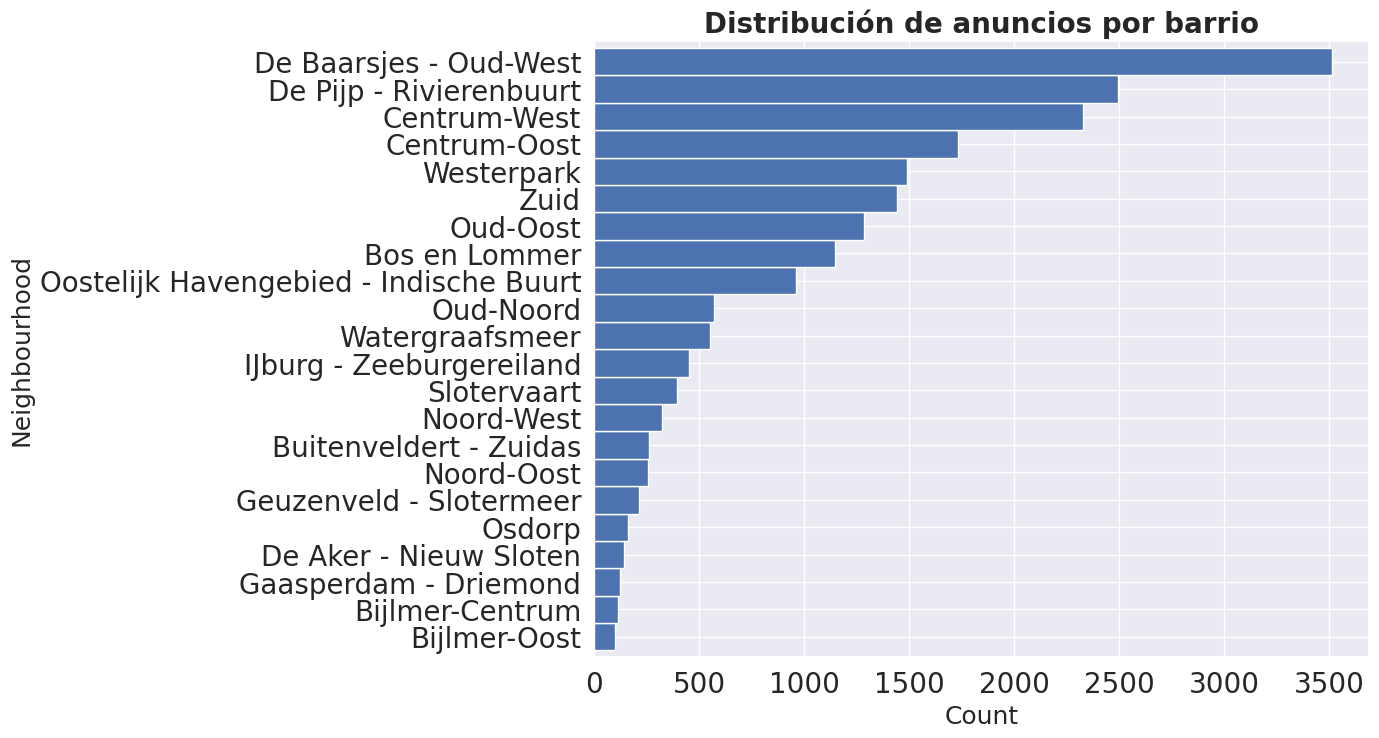

In [15]:
feq.plot.barh(figsize=(10,8), fontsize=20, color = "b", width=1)
plt.title("Distribución de anuncios por barrio", fontsize=20, fontweight='bold')
plt.xlabel("Count", fontsize=18)
plt.ylabel("Neighbourhood", fontsize=18)
plt.show()

In [16]:
px.bar(feq, orientation='h', title = "Number of listings by neighbourhood", template= "plotly_dark")

In [17]:
lats2018 = listings['latitude'].tolist()
lons2018 = listings['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[52.3680, 4.9036], zoom_start=12)
FastMarkerCluster(data=locations).add_to(map1)

map1



In [18]:
px.scatter_mapbox(listings, lat='latitude', lon='longitude', size='price', zoom=10, mapbox_style='carto-positron', title='AirBnb Apartment Distribution in Amsterdam', template= "plotly_dark", size_max=20, animation_frame='room_type')

### Tipos de habitaciones y propiedades 

In [19]:
freq = listings['room_type']. value_counts().sort_values(ascending=True)


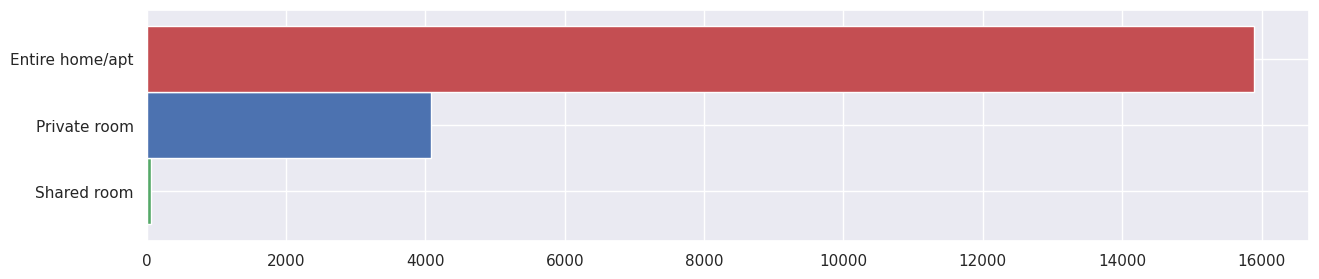

In [20]:
freq.plot.barh(figsize=(15, 3), width=1, color = ["g","b","r"])
plt.show()

In [21]:
px.histogram(listings,'room_type',nbins = 20,template= "plotly_dark")

In [24]:
listings.property_type.unique()

array(['Apartment', 'Townhouse', 'Houseboat', 'Bed and breakfast', 'Boat',
       'Guest suite', 'Loft', 'Serviced apartment', 'House',
       'Boutique hotel', 'Guesthouse', 'Other', 'Condominium', 'Chalet',
       'Nature lodge', 'Tiny house', 'Hotel', 'Villa', 'Cabin',
       'Lighthouse', 'Bungalow', 'Hostel', 'Cottage', 'Tent',
       'Earth house', 'Campsite', 'Castle', 'Camper/RV', 'Barn',
       'Casa particular (Cuba)', 'Aparthotel'], dtype=object)

In [26]:
prop = listings.groupby(['property_type', "room_type"]).room_type.count()
prop = prop.unstack()
prop.T

property_type    Aparthotel  Apartment  Barn  Bed and breakfast   Boat  \
room_type                                                                
Entire home/apt        60.0    12990.0   1.0               23.0  257.0   
Private room           12.0     2550.0   3.0              426.0  113.0   
Shared room             1.0       42.0   NaN                6.0    2.0   

property_type    Boutique hotel  Bungalow  Cabin  Camper/RV  Campsite  \
room_type                                                               
Entire home/apt             2.0      10.0   10.0        1.0       2.0   
Private room               26.0       2.0    4.0        1.0       NaN   
Shared room                 NaN       NaN    NaN        NaN       NaN   

property_type    Casa particular (Cuba)  Castle  Chalet  Condominium  Cottage  \
room_type                                                                       
Entire home/apt                     3.0     1.0     1.0        252.0     10.0   
Private room                        2.0     NaN     2.0         69.0      1.0   
Shared room                         NaN     NaN     NaN          2.0      1.0   

property_type    Earth house  Guest suite  Guesthouse  Hostel  Hotel   House  \
room_type                                                                      
Entire home/apt          1.0         36.0        17.0     NaN    1.0  1159.0   
Private room             NaN        116.0        26.0     4.0    6.0   361.0   
Shared room              NaN          NaN         NaN     NaN    NaN     3.0   

property_type    Houseboat  Lighthouse   Loft  Nature lodge  Other  \
room_type                                                            
Entire home/apt      154.0         1.0  319.0           1.0   23.0   
Private room          69.0         NaN   63.0           NaN   28.0   
Shared room            2.0         NaN    2.0           NaN    NaN   

property_type    Serviced apartment  Tent  Tiny house  Townhouse  Villa  
room_type                                                                
Entire home/apt                52.0   NaN         2.0      477.0   23.0  
Private room                   11.0   1.0         3.0      168.0    9.0  
Shared room                     NaN   NaN         NaN        4.0    NaN

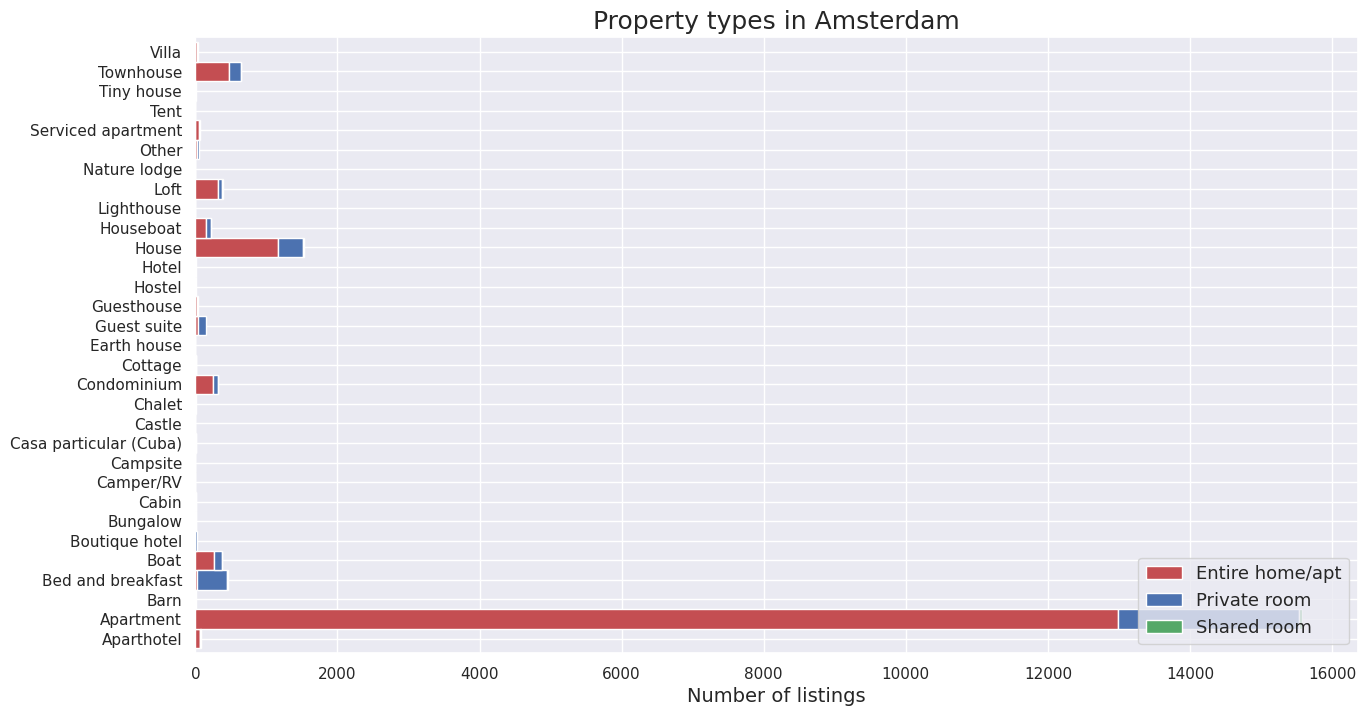

In [27]:
prop.plot(kind='barh',stacked=True, color = ["r","b","g"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Property types in Amsterdam', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

In [28]:
px.bar(prop,barmode="group",color_discrete_map={"Entire home/apt":"red","Private room":"yellow","Shared room":"green"}, template = "plotly_dark")

### Huéspedes

In [29]:
feq=listings['accommodates'].value_counts().sort_index()


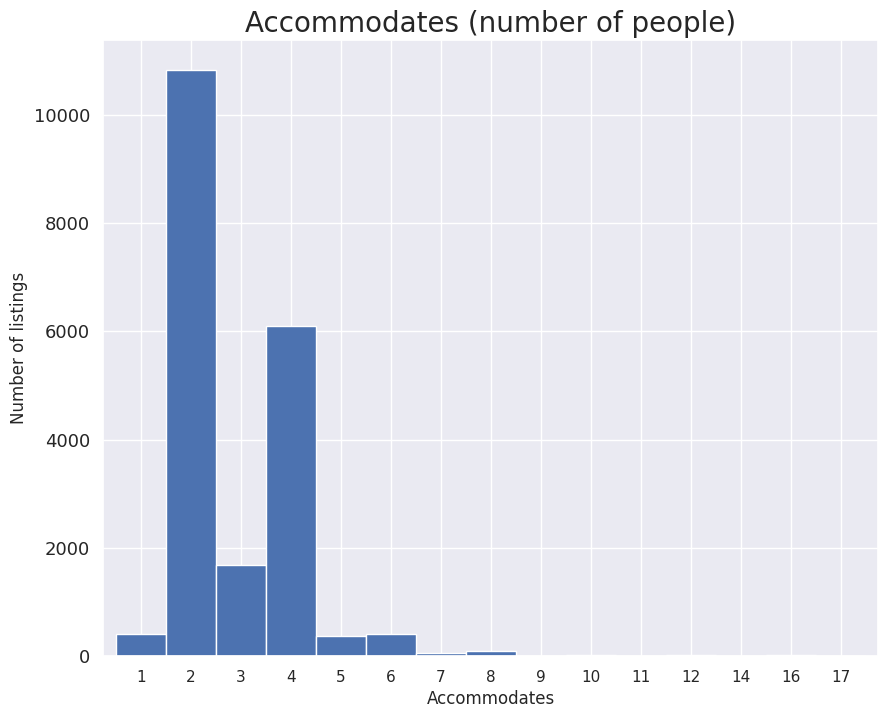

In [30]:
feq.plot.bar(figsize=(10, 8), color='b', width=1, rot=0)
plt.title("Accommodates (number of people)", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

In [31]:
px.bar(feq,title= "Number of accomodates in Amsterdam",template= "plotly_dark", labels=dict(index="Accomodates",value="Listings"), width = 1000)

### Encontrando potenciales hoteles ilegales

Las reglas adicionales que tiene Ámsterdam en comparación con las propias reglas de Airbnb son:

* El número máximo de invitados es de 4 (ver también apartado anterior)
* El número máximo para el alquiler a corto plazo es de 60 días por año calendario. Esta regla es solo para el alquiler de propiedades completas y, por lo tanto, no se aplica al alquiler de habitaciones privadas. Esta regla ya fue implementada por Airbnb (después de 60 días de reservas, Airbnb cierra la disponibilidad del listado por el resto del año). Como se puede leer en el artículo, el número se reducirá a un máximo de 30 días al año.
* Amsterdam tiene la intención de prohibir Airbnb por completo en tres barrios: de Wallen (Distrito Rojo), Kinkerbuurt y Haarlemmerbuurt
* Para el alquiler de Habitaciones Privadas, también existe la restricción de que un propietario no puede alquilar habitaciones que acumulen más del 40% de la superficie total (en metros cuadrados)

In [32]:
private = listings[listings['room_type'] == "Private room"]
host_private = private.groupby(['host_id', 'host_name', 'street']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)

In [33]:
host_private.head()

host_id  host_name                                   street  \
2436   67005410  Feliciano    Amsterdam, Noord-Holland, Netherlands   
918    10076897  Geraldine    Amsterdam, Noord-Holland, Netherlands   
2113   44168250      Ruben    Amsterdam, Noord-Holland, Netherlands   
1570   22879651      Wamme    Amsterdam, Noord-Holland, Netherlands   
3209  174174070     Amrath  Badhoevedorp, Badhoevedorp, Netherlands   

      private_rooms  
2436             15  
918              13  
2113             13  
1570              7  
3209              7

In [34]:
feliciano = private[private['host_id']== 67005410]
feliciano = feliciano[['name','host_id', 'host_name', 'latitude', 'longitude']]
feliciano.index.name = "listing_id"
feliciano


name   host_id  \
listing_id                                                             
12392592                Hotel in the heart of Amsterdam 2p  67005410   
12444222                Hotel in the heart of Amsterdam 4p  67005410   
12446710                Hotel in the heart of Amsterdam 3p  67005410   
12451293      Hotel in the heart of Amsterdam, Single room  67005410   
12579177                Hotel in the heart of Amsterdam 2p  67005410   
12582071                Hotel in the heart of Amsterdam 3p  67005410   
12865293                Hotel in the heart of Amsterdam 2p  67005410   
12865495                Hotel in the heart of Amsterdam 2p  67005410   
12898673                Hotel in the heart of Amsterdam 1p  67005410   
12908561      Hotel in the heart of Amsterdam, Single room  67005410   
13086175                  Studio in the heart of Amsterdam  67005410   
13092978                Hotel in the heart of Amsterdam 2p  67005410   
13584858    Hotel in the heart of Amsterdam, Basement Room  67005410   
16863015      Hotel in the heart of Amsterdam, Double room  67005410   
20913032      Hotel in the heart of Amsterdam, Single room  67005410   

            host_name   latitude  longitude  
listing_id                                   
12392592    Feliciano  52.375251   4.900321  
12444222    Feliciano  52.375130   4.899694  
12446710    Feliciano  52.374695   4.900266  
12451293    Feliciano  52.374682   4.898916  
12579177    Feliciano  52.374567   4.898310  
12582071    Feliciano  52.373407   4.900022  
12865293    Feliciano  52.375077   4.900191  
12865495    Feliciano  52.373396   4.898427  
12898673    Feliciano  52.373346   4.898344  
12908561    Feliciano  52.375454   4.899639  
13086175    Feliciano  52.373261   4.898612  
13092978    Feliciano  52.373547   4.898366  
13584858    Feliciano  52.373557   4.899852  
16863015    Feliciano  52.373508   4.898867  
20913032    Feliciano  52.373674   4.898825

In [35]:
map2 = folium.Map(location=[52.3680, 4.9036], zoom_start=13)
for coord in feliciano.itertuples(index=False):
    folium.Marker((coord.latitude, coord.longitude), tooltip=coord.name).add_to(map2)
map2

In [40]:
freq = listings.groupby(['host_id']).size().reset_index(name='num_host_listings')

malvados = freq[freq['num_host_listings']>=20] 
px.pie(malvados,'num_host_listings',hover_data=['host_id'],title = 'Hosts with more than 20 listings',template= "plotly_dark")

### Precios por vecindarios

In [63]:
feq = listings[listings['accommodates']==2]
feq = feq.groupby("neighbourhood")["price"].mean().sort_values(ascending=True)


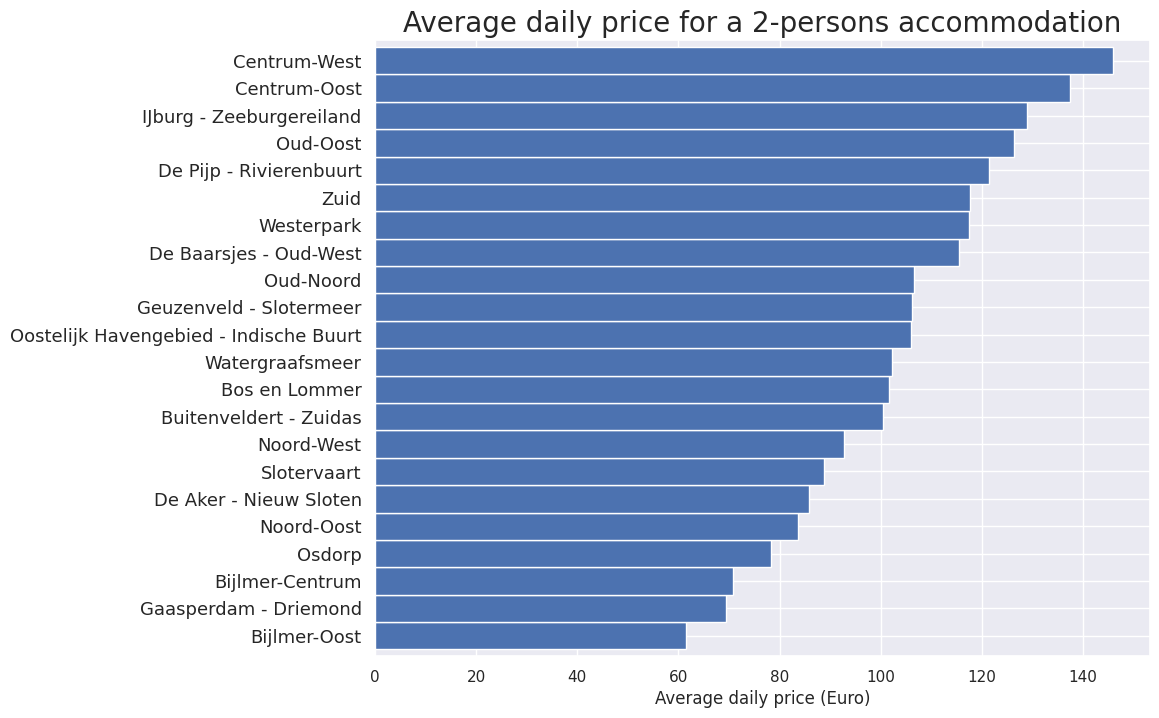

In [42]:
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=12)
plt.ylabel("")
plt.show()

In [44]:
precio = listings.groupby('neighbourhood')['price'].mean().sort_values(ascending = False)
dfprecio = pd.DataFrame(precio)
dfprecio = dfprecio.reset_index()
#ahora graficamos con plotly
px.area(dfprecio, x="neighbourhood", y="price",template= "plotly_dark", title = "Average daily price based on location in Amsterdam")

In [45]:
px.treemap(dfprecio,path=["neighbourhood"],values="price", template= "plotly_dark", title="Average daily price based on location in Amsterdam" )

### Mapa de zona

In [47]:
adam = gpd.read_file("input/neighbourhoods.geojson")
feq = feq.transpose()
adam = pd.merge(adam, feq, on='neighbourhood', how='left')
adam.rename(columns= {"price":"avg_price"}, inplace= True)
adam.avg_price = adam.avg_price.round(decimals=2)



In [49]:
map_dict = adam.set_index('neighbourhood')['avg_price'].to_dict()
color_scale = LinearColormap(["yellow", "red"], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    if value is not None:
        return color_scale(value)
    else:
        return 'grey'

In [52]:
map3 = folium.Map(location=[52.3680, 4.9036], zoom_start=11)
folium.GeoJson(data=adam,
               name='Amsterdam',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'avg_price'],
                                                      labels=True,
                                                      sticky=True),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.9
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)

In [53]:
map3

In [54]:
fig = px.choropleth_mapbox(dfprecio, geojson=adam, featureidkey='properties.neighbourhood',locations ="neighbourhood",color = 'price', 
                            color_continuous_scale="portland", title="Neighbourhoods in Amsterdam",zoom=10, hover_data = ['neighbourhood','price'],
                            mapbox_style="carto-positron",width=1000, height=750,center = {"lat": 52.3680, "lon": 4.9036})
fig.update(layout_coloraxis_showscale=True)
fig.update_layout( paper_bgcolor="#1f2630",font_color="white",title_font_size=20, title_x = 0.5)
fig.show()

## Seguridad

## 4.2 Seguridad del vecindario

Como no hay datos sobre la seguridad del vecindario en los archivos de Airbnb, en `imgur` se pueden encontrar datos adicionales a este respecto. Como puedes ver, hoy en día las partes occidentales de la ciudad son las más peligrosas.


<center><img src="https://i.imgur.com/7cso9GD.png" style="width: 800px;"/></center>

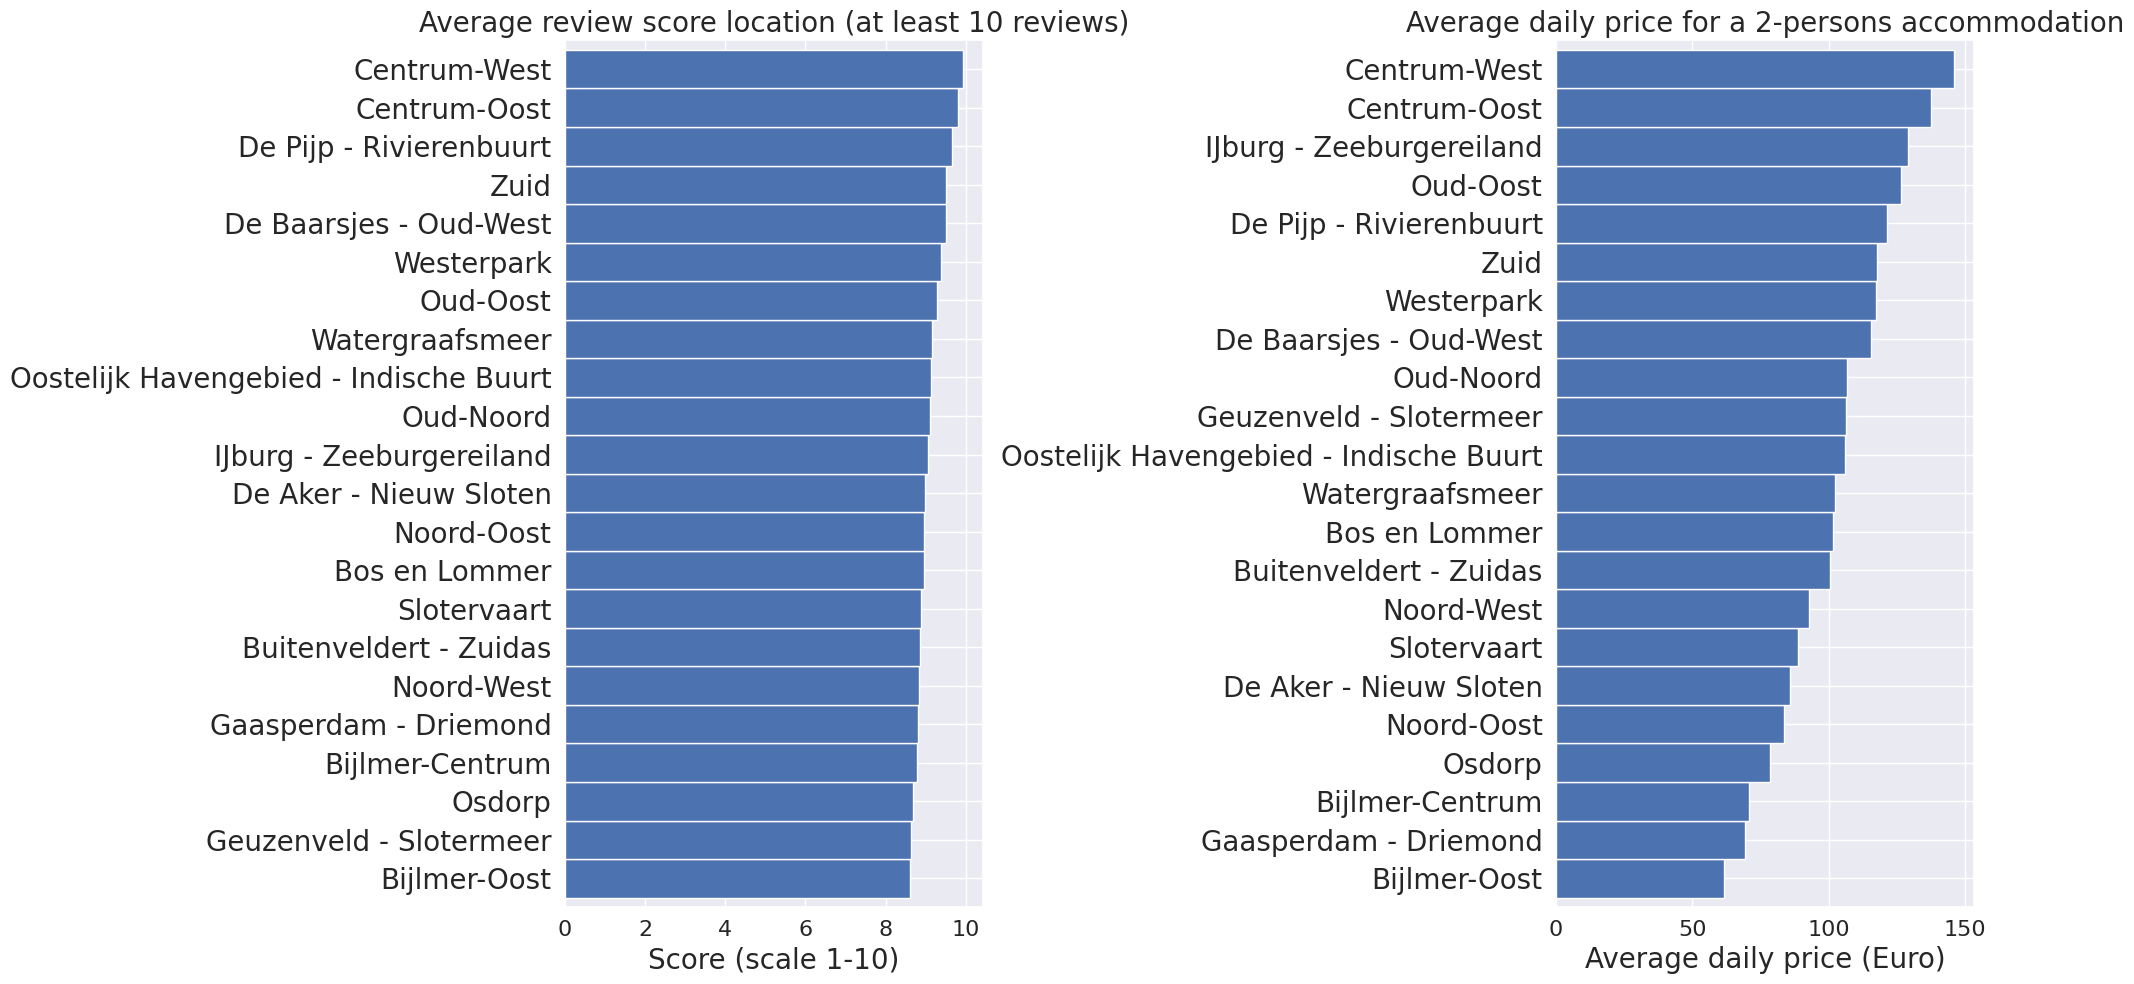

In [55]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = listings[listings['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = listings[listings['accommodates']==2]
feq2 = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
ax2=feq2.plot.barh(color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()

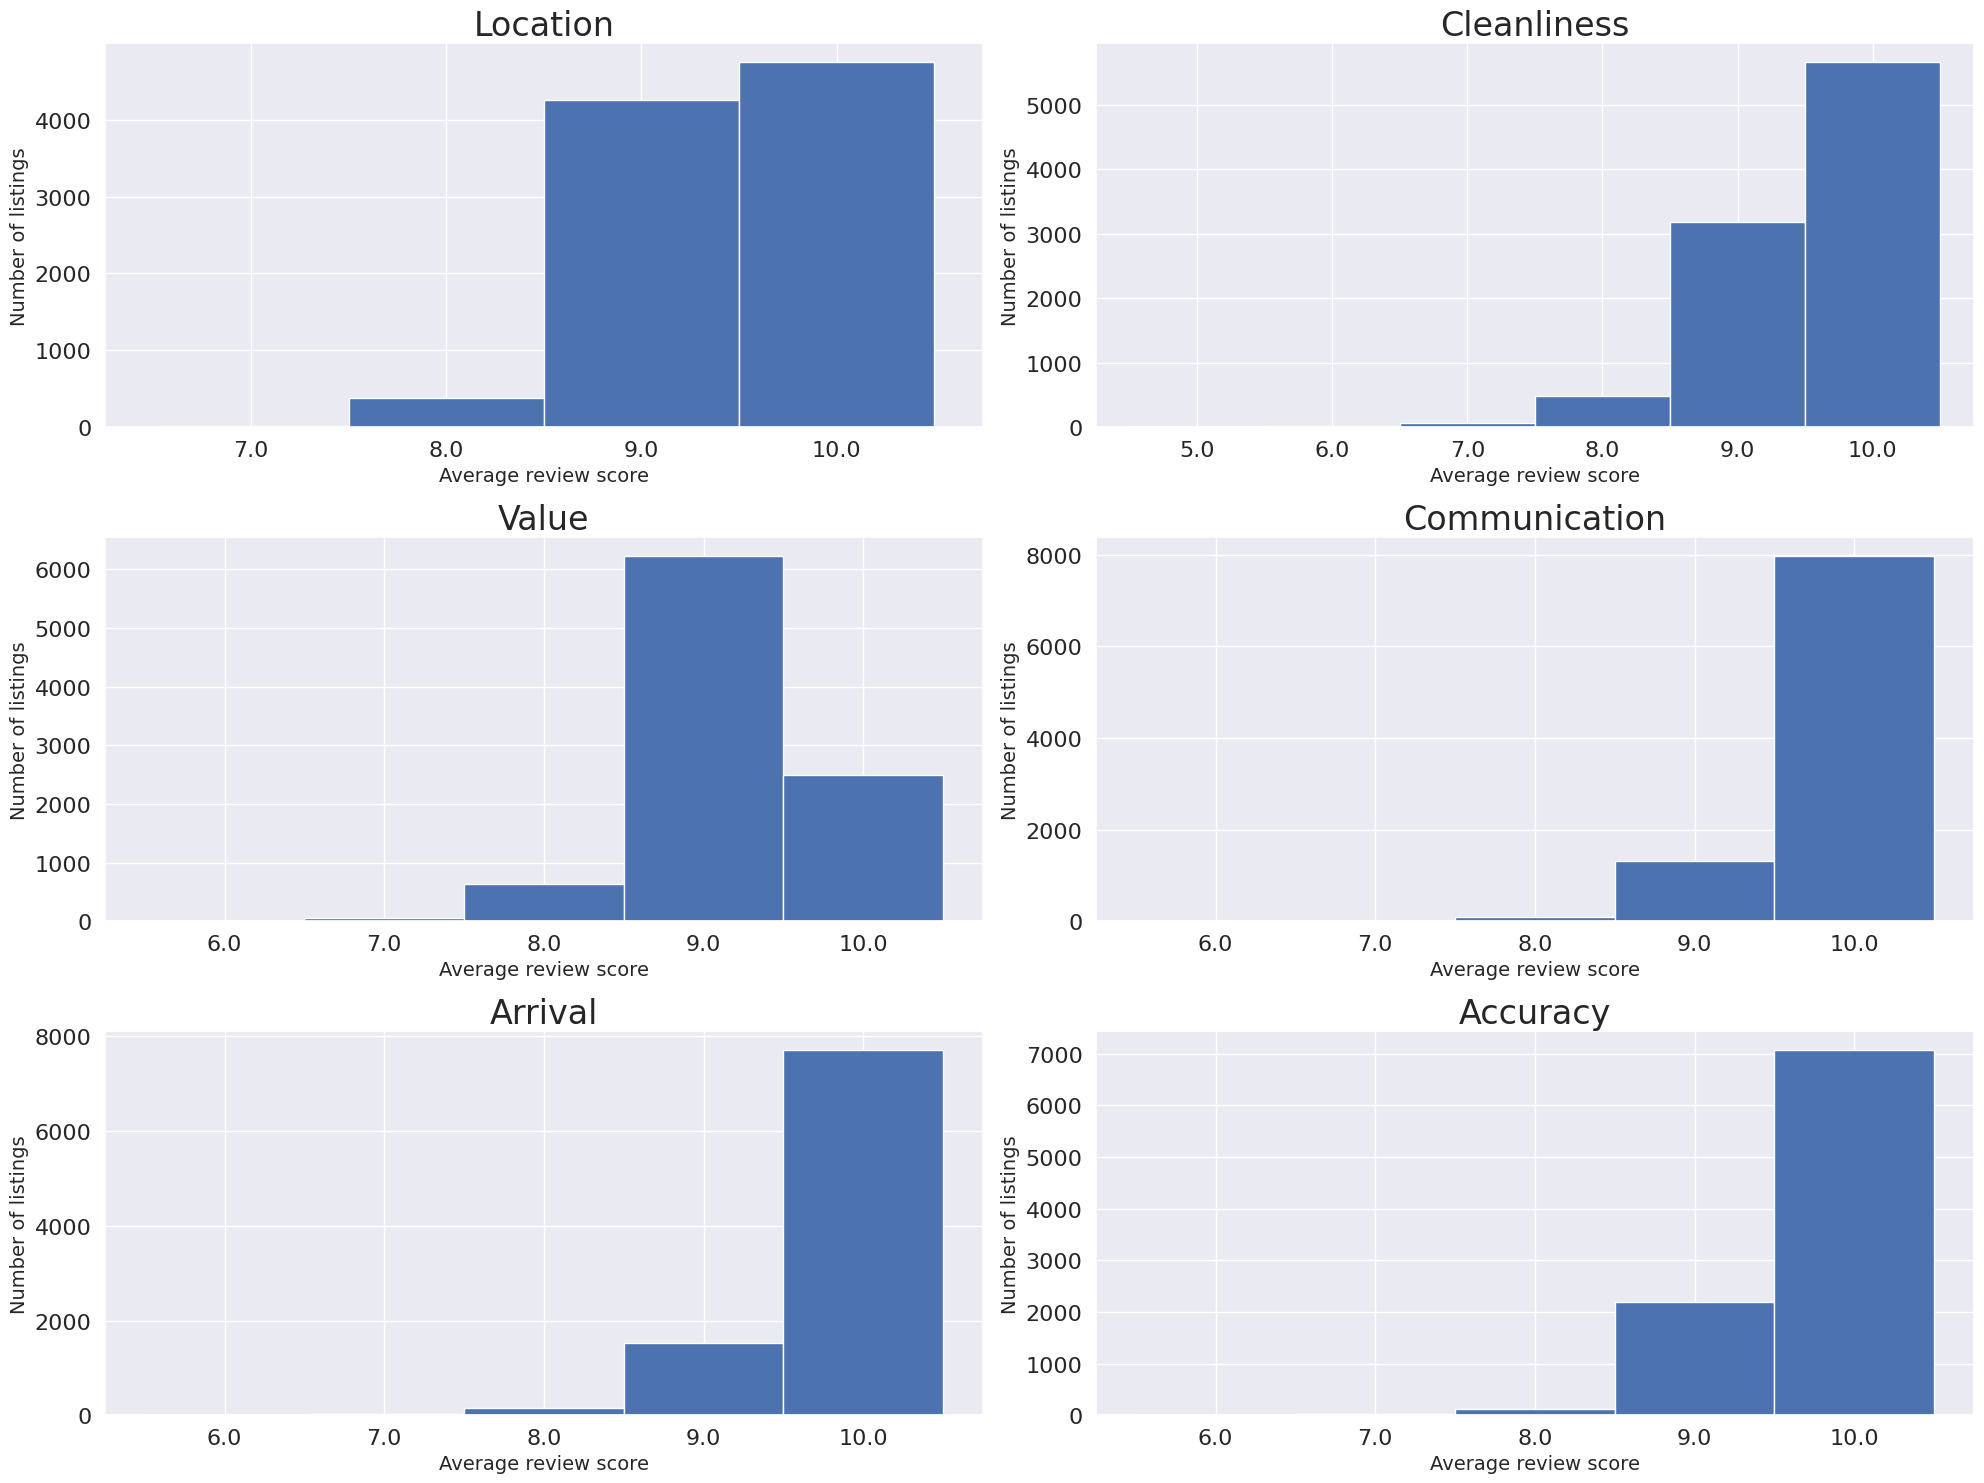

In [56]:
listings10 = listings[listings['number_of_reviews']>=10]

fig = plt.figure(figsize=(20,15))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

ax1 = fig.add_subplot(321)
feq=listings10['review_scores_location'].value_counts().sort_index()
ax1=feq.plot.bar(color='b', width=1, rot=0)
#ax1.tick_params(axis = 'both', labelsize = 16)
plt.title("Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax2 = fig.add_subplot(322)
feq=listings10['review_scores_cleanliness'].value_counts().sort_index()
ax2=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax3 = fig.add_subplot(323)
feq=listings10['review_scores_value'].value_counts().sort_index()
ax3=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax4 = fig.add_subplot(324)
feq=listings10['review_scores_communication'].value_counts().sort_index()
ax4=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax5 = fig.add_subplot(325)
feq=listings10['review_scores_checkin'].value_counts().sort_index()
ax5=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Arrival", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax6 = fig.add_subplot(326)
feq=listings10['review_scores_accuracy'].value_counts().sort_index()
ax6=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

plt.tight_layout()
plt.show()

In [57]:
listings.host_is_superhost  = listings.host_is_superhost.replace({"t": "True", "f": "False"})


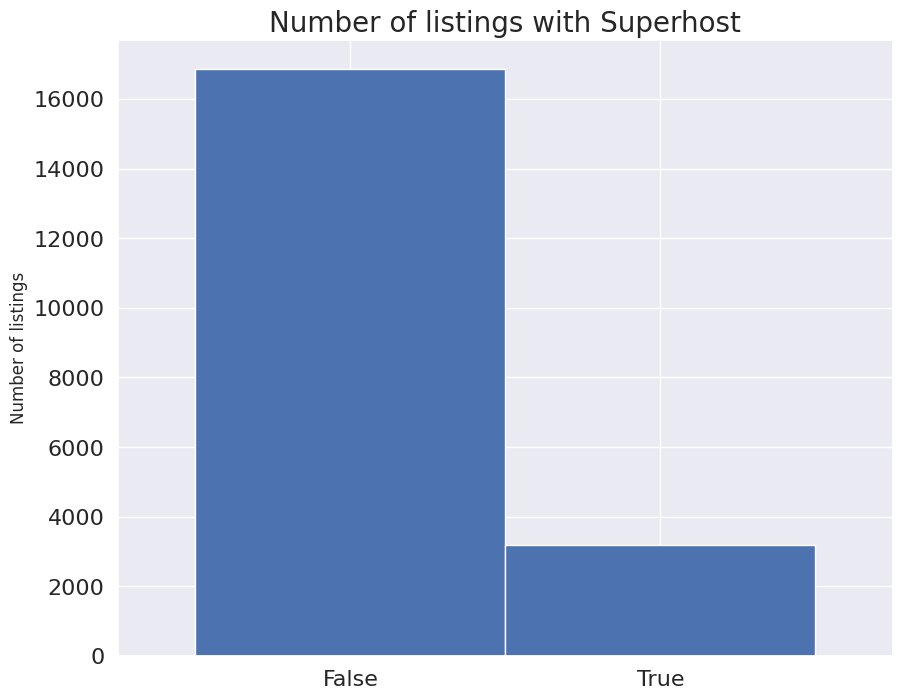

In [58]:
feq=listings['host_is_superhost'].value_counts()
feq.plot.bar(figsize=(10, 8), width=1, rot=0)
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.show()

In [59]:
px.pie(feq ,names = feq.index, values=feq.values,width = 1000, template= "plotly_dark", title="Number of listings with Superhost")

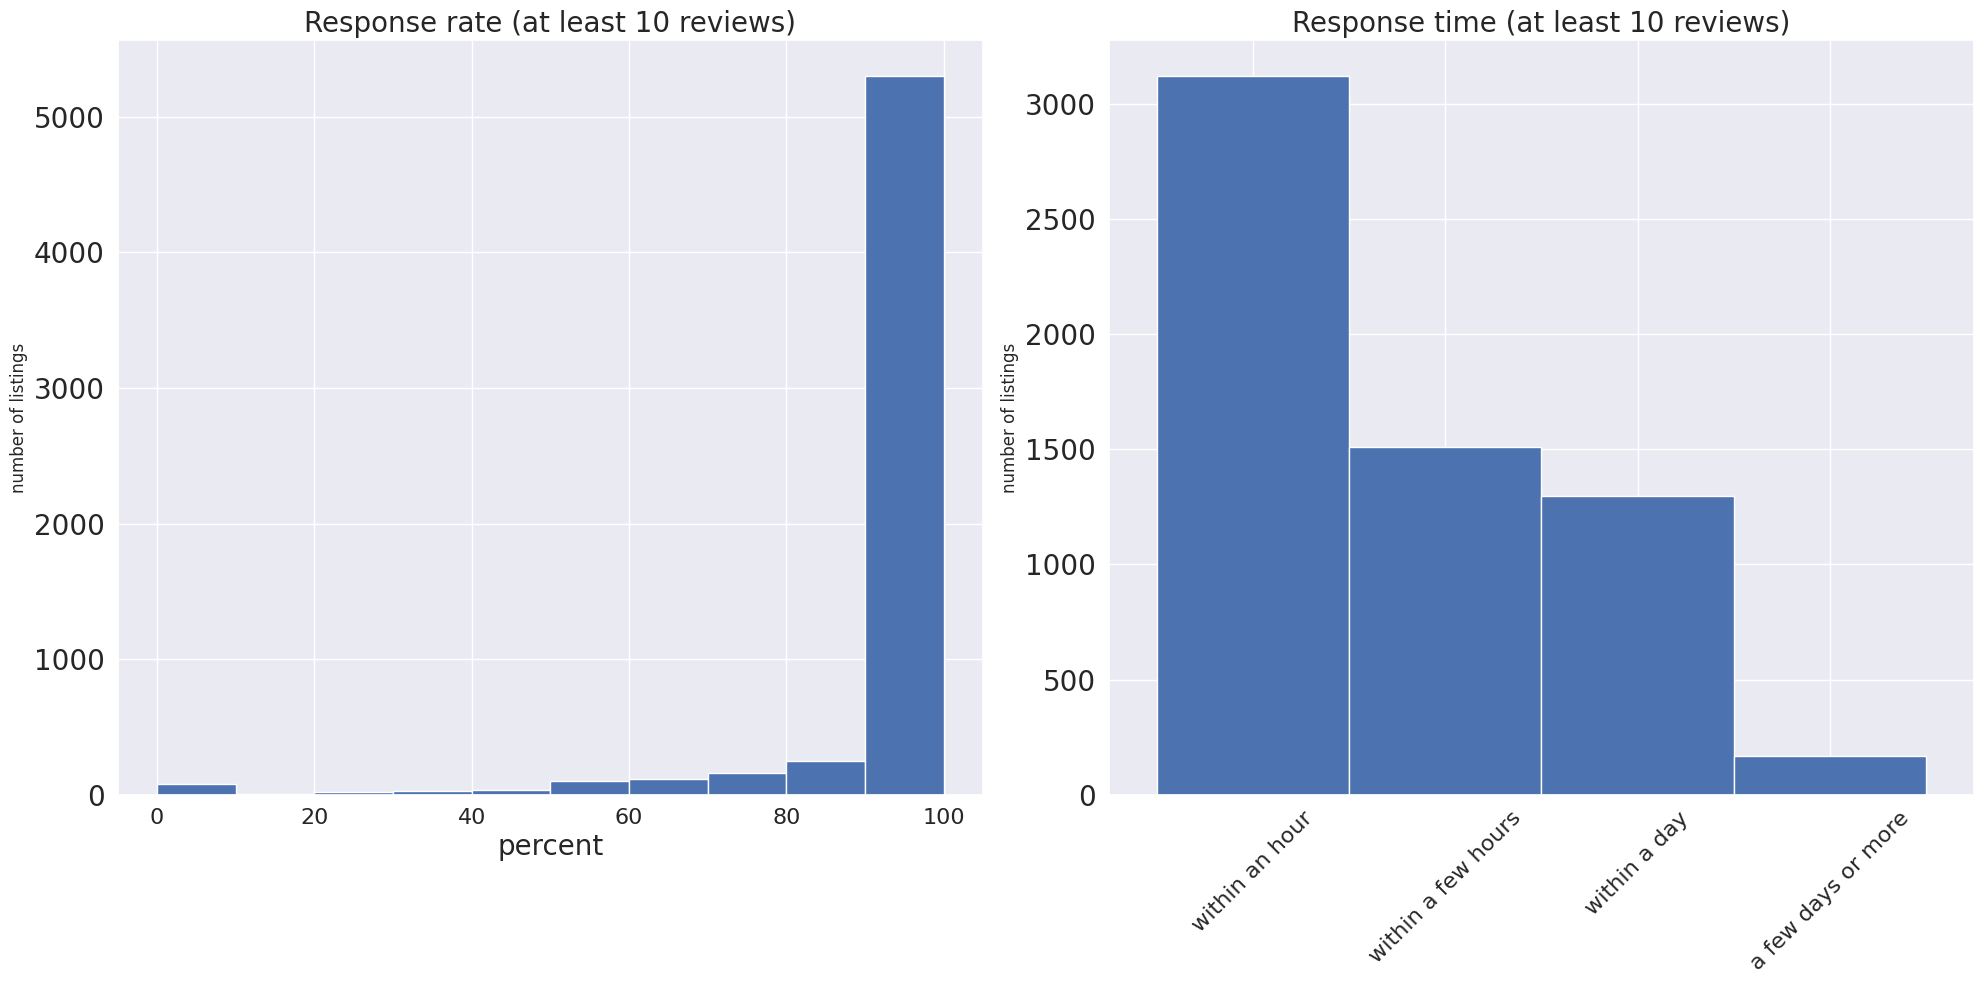

In [60]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq1 = listings10['host_response_rate'].dropna()
ax1= plt.hist(feq1)
plt.title("Response rate (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")
plt.xlabel("percent", fontsize=20)

ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()
ax2=feq2.plot.bar(color='b', width=1, rot=45)
plt.title("Response time (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")

plt.tight_layout()
plt.show()

In [61]:
calendar

date available    price
listing_id                              
2818       2019-12-05         f      NaN
73208      2019-08-30         f      NaN
73208      2019-08-29         f      NaN
73208      2019-08-28         f      NaN
73208      2019-08-27         f      NaN
...               ...       ...      ...
29979667   2018-12-11         t  $139.00
29979667   2018-12-10         t  $139.00
29979667   2018-12-09         t  $139.00
29979667   2018-12-08         t  $139.00
29979667   2018-12-07         t  $139.00

[7310950 rows x 3 columns]

In [67]:
average_price

weekday
date                 
2018-12-06   Thursday
2018-12-07     Friday
2018-12-08   Saturday
2018-12-09     Sunday
2018-12-10     Monday
...               ...
2019-12-02     Monday
2019-12-03    Tuesday
2019-12-04  Wednesday
2019-12-05   Thursday
2019-12-06     Friday

[366 rows x 1 columns]

In [ ]:
average_price = calendar[(calendar.available == "t")].groupby(['date']).mean().astype(np.int64).reset_index()
average_price['weekday'] = average_price['date'].dt.day_name()
average_price = average_price.set_index('date')

average_price.iplot(y='price', mode='lines', xTitle='Date', yTitle='Price', #Reparar
    text='weekday', title='Average price of available 2 persons accommodation by date')

In [68]:
reviews_details.shape

(431830, 6)

In [69]:
reviews_details

listing_id         id       date  reviewer_id  reviewer_name  \
0             2818       1191 2009-03-30        10952            Lam   
1             2818       1771 2009-04-24        12798          Alice   
2             2818       1989 2009-05-03        11869        Natalja   
3             2818       2797 2009-05-18        14064        Enrique   
4             2818       3151 2009-05-25        17977        Sherwin   
...            ...        ...        ...          ...            ...   
431825    30435529  355474875 2018-12-04    131376847           Andy   
431826    30439111  355041813 2018-12-02    103201416       Mohammed   
431827    30518120  355519016 2018-12-04    228738702       Valeriya   
431828    30525429  355658538 2018-12-05    111439550          Lucas   
431829    30550093  355872191 2018-12-06    226911176  Mohamed Amine   

                                                 comments  
0       Daniel is really cool. The place was nice and ...  
1       Daniel is the most amazing host! His place is ...  
2       We had such a great time in Amsterdam. Daniel ...  
3       Very professional operation. Room is very clea...  
4       Daniel is highly recommended.  He provided all...  
...                                                   ...  
431825  The host canceled this reservation the day bef...  
431826  The host canceled this reservation 20 days bef...  
431827  The host canceled this reservation 22 days bef...  
431828  I loved this house! It is truly incredible and...  
431829                              I love it I recommend  

[431830 rows x 6 columns]

In [73]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'property_type',
       'accommodates', 'first_review', 'review_scores_value',
       'review_scores_cleanliness', 'review_scores_location',
       'review_scores_accuracy', 'review_scores_communication',
       'review_scores_checkin', 'review_scores_rating', 'maximum_nights',
       'listing_url', 'host_is_superhost', 'host_about', 'host_response_time',
       'host_response_rate', 'street', 'weekly_price', 'monthly_price',
       'market'],
      dtype='object')

In [74]:
reviews_details.columns

Index(['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id',
       'reviewer_name', 'comments'],
      dtype='object')

In [78]:
reviews_details = pd.merge(reviews_details, listings[['host_id', 'host_name', 'name']], on = "host_id", how = "left")
reviews_details = reviews_details[['listing_id', 'host_id', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
reviews_details.head()